Source: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/tree/master/tensorflow-rnn-tutorial

Compared to the original (source) model, the model has been adjusted to increase accuracy.

# An RNN model for temperature data
This time we will be working with real data: daily (Tmin, Tmax) temperature series from 1666 weather stations spanning 50 years. It is to be noted that a pretty good predictor model already exists for temperatures: the average of temperatures on the same day of the year in N previous years. It is not clear if RNNs can do better but we will se how far they can go.

<div class="alert alert-block alert-info">
Things to do:<br/>
<ol start="0">
    <li>Run the notebook as it is. Look at the data visualisations. Then look at the predictions at the end. Not very good...
    <li>Fist play with the data to find good values for RESAMPLE_BY and SEQLEN in hyperparameters ([Assignment #1](#assignment1)).
    <li>Now implement the RNN model in the model function ([Assignment #2](#assignment2)).
<li>Temperatures are noisy, let's try something new: predicting N data points ahead  instead of only 1 ahead ([Assignment #3](#assignment3)).
<li>Now we will adjust more traditional hyperparameters and add regularisations. ([Assignment #4](#assignment4))
<li>
Look at the save-restore code. The model is saved at the end of the [training loop](#train) and restored when running [validation](#valid). Also see how the restored model is used for [inference](#inference).
    <br/><br/>
You are ready to run in the cloud on all 1666 weather stations. Use [this bash notebook](../run-on-cloud-ml-engine.ipynb) to convert your code to a regular Python file and invoke the Google Cloud ML Engine command line.
When the training is finished on ML Engine, change one line in [validation](#valid) to load the SAVEDMODEL from its cloud bucket and display.
</div>

In [1]:
# (1) How about leap years?

In [2]:
import math
import sys
import time
import numpy as np
import utils_batching
import utils_args
import tensorflow as tf
from tensorflow.python.lib.io import file_io as gfile
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.12.0


In [3]:
import pandas
import pandas.plotting._converter as pandacnv
pandacnv.register()

from matplotlib import pyplot as plt
import utils_prettystyle
import utils_display

<a name="hyperparameters"></a>
<a name="assignment1"></a>
## Hyperparameters

<div class="alert alert-block alert-info">
***Assignment #1*** Temperatures have a periodicity of 365 days. We would need to unroll the RNN over 365 steps (=SEQLEN) to capture that. That is way too much. We will have to work with averages over a handful of days instead of daily temperatures. Bump the unrolling length to SEQLEN=128 and then try averaging over 3 to 5 days (RESAMPLE_BY=3, 4, 5). Look at the data visualisations in [Resampling](#resampling) and [Training sequences](#trainseq). The training sequences should capture a recognizable part of the yearly oscillation.
***In the end, use these values: SEQLEN=128, RESAMPLE_BY=5.***
</div>

In [4]:
NB_EPOCHS = 10       # number of times the model sees all the data during training

RESAMPLE_BY = 5     # averaging period in days (training on daily data is too much)
SEQLEN = 128         # unrolled sequence length

DATA_SIZE = 2       # 2 variables: Tmin, Tmax; Can also be found as: DATA_SIZE==tf.shape(X)[2]

N_FORWARD = 8       # train the network to predict N in advance (traditionnally 1)
RNN_CELLSIZE = 128   # size of the RNN cells
N_LAYERS = 2        # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
BATCHSIZE = 64      # mini-batch size
DROPOUT_PKEEP = 0.75 # dropout: probability of neurons being kept (NOT dropped). Should be between 0.5 and 1.
ACTIVATION = tf.nn.tanh # Activation function for GRU cells (tf.nn.relu or tf.nn.tanh)

JOB_DIR  = "checkpoints"
DATA_DIR = "temperatures"

# potentially override some settings from command-line arguments
if __name__ == '__main__':
    JOB_DIR, DATA_DIR = utils_args.read_args1(JOB_DIR, DATA_DIR)

ALL_FILEPATTERN = DATA_DIR + "/*.csv" # pattern matches all 1666 files  
EVAL_FILEPATTERN = DATA_DIR + "/USC000*2.csv" # pattern matches 8 files
# pattern USW*.csv -> 298 files, pattern USW*0.csv -> 28 files
print('Reading data from "{}".\nWrinting checkpoints to "{}".'.format(DATA_DIR, JOB_DIR))

Reading data from "temperatures".
Wrinting checkpoints to "checkpoints".


## Temperature data
This is what our temperature datasets looks like: sequences of daily (Tmin, Tmax) from 1960 to 2010. They have been cleaned up and eventual missing values have been filled by interpolation. Interpolated regions of the dataset are marked in red on the graph.

In [5]:
all_filenames = gfile.get_matching_files(ALL_FILEPATTERN)
eval_filenames = gfile.get_matching_files(EVAL_FILEPATTERN)
train_filenames = list(set(all_filenames) - set(eval_filenames))

# By default, this utility function loads all the files and places data
# from them as-is in an array, one file per line. Later, we will use it
# to shape the dataset as needed for training.
ite = utils_batching.rnn_multistation_sampling_temperature_sequencer(eval_filenames)
evtemps, _, evdates, _, _ = next(ite) # gets everything

print('Pattern "{}" matches {} files'.format(ALL_FILEPATTERN, len(all_filenames)))
print('Pattern "{}" matches {} files'.format(EVAL_FILEPATTERN, len(eval_filenames)))
print("Evaluation files: {}".format(len(eval_filenames)))
print("Training files: {}".format(len(train_filenames)))
print("Initial shape of the evaluation dataset: " + str(evtemps.shape))
print("{} files, {} data points per file, {} values per data point"
      " (Tmin, Tmax, is_interpolated) ".format(evtemps.shape[0], evtemps.shape[1],evtemps.shape[2]))

Loading 8 files........
Pattern "temperatures/*.csv" matches 36 files
Pattern "temperatures/USC000*2.csv" matches 8 files
Evaluation files: 8
Training files: 28
Initial shape of the evaluation dataset: (8, 18262, 3)
8 files, 18262 data points per file, 3 values per data point (Tmin, Tmax, is_interpolated) 


In [6]:
evtemps.shape[1]

18262

In [7]:
365*5

1825

In [8]:
evdates

array(['1960-01-02', '1960-01-03', '1960-01-04', ..., '2009-12-29',
       '2009-12-30', '2009-12-31'], dtype='datetime64[D]')

In [9]:
evtemps[7,:50]

array([[-4.4 , 10.  ,  0.  ],
       [-3.3 ,  8.3 ,  0.  ],
       [ 2.8 , 12.2 ,  0.  ],
       [-3.9 , 17.8 ,  0.  ],
       [-0.6 , 10.6 ,  0.  ],
       [ 1.7 , 11.1 ,  0.  ],
       [ 5.  , 13.3 ,  0.  ],
       [ 6.1 , 13.3 ,  0.  ],
       [ 6.1 ,  8.9 ,  0.  ],
       [ 4.4 , 11.1 ,  0.  ],
       [-0.6 , 12.2 ,  0.  ],
       [ 0.6 , 11.7 ,  0.  ],
       [ 2.2 , 10.6 ,  0.  ],
       [-0.6 ,  7.2 ,  0.  ],
       [ 3.9 , 12.2 ,  0.  ],
       [-1.7 , 14.4 ,  0.  ],
       [-0.6 , 11.1 ,  0.  ],
       [ 1.7 ,  8.9 ,  0.  ],
       [ 3.9 , 12.2 ,  0.  ],
       [ 3.9 , 12.2 ,  0.  ],
       [ 6.7 , 10.  ,  0.  ],
       [ 6.7 , 17.2 ,  0.  ],
       [ 7.8 , 13.9 ,  0.  ],
       [ 8.3 , 13.3 ,  0.  ],
       [ 9.4 , 15.6 ,  0.  ],
       [ 7.8 , 15.  ,  0.  ],
       [ 8.9 , 14.4 ,  0.  ],
       [ 5.  , 16.7 ,  0.  ],
       [ 8.9 , 16.1 ,  0.  ],
       [ 5.  , 17.8 ,  0.  ],
       [ 9.4 , 15.6 ,  0.  ],
       [ 4.4 , 16.7 ,  0.  ],
       [ 6.1 , 16.7 ,  0.  ],
       [ 6

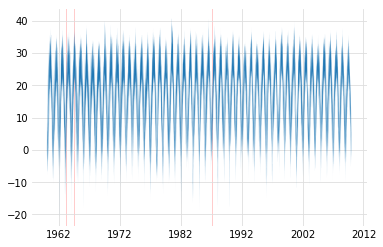

In [10]:
# You can adjust the visualisation range and dataset here.
# Interpolated regions of the dataset are marked in red.
WEATHER_STATION = 0 # 0 to 7 in default eval dataset
START_DATE = 0      # 0 = Jan 2nd 1950
END_DATE = evtemps.shape[1]    # 18262 = Dec 31st 2009
visu_temperatures = evtemps[WEATHER_STATION,START_DATE:END_DATE]
visu_dates = evdates[START_DATE:END_DATE]

utils_display.picture_this_4(visu_temperatures, visu_dates)

<a name="resampling"></a>
## Resampling
Our RNN would need ot be unrolled across 365 steps to capture the yearly temperature cycles. That's a bit too much. We will resample the temparatures and work with 5-day averages for example. This is what resampled (Tmin, Tmax) temperatures look like.

In [11]:
# This time we ask the utility function to average temperatures over 5-day periods (RESAMPLE_BY=5)
ite = utils_batching.rnn_multistation_sampling_temperature_sequencer(eval_filenames, RESAMPLE_BY, tminmax=True)
evaltemps, _, evaldates, _, _ = next(ite)

Loading 8 files........


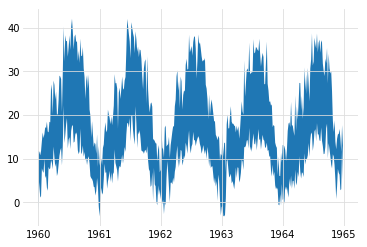

In [12]:
# display five years worth of data
WEATHER_STATION = 0              # 0 to 7 in default eval dataset
START_DATE = 0                   # 0 = Jan 2nd 1950
END_DATE = 365*5//RESAMPLE_BY    # 5 years
visu_temperatures = evaltemps[WEATHER_STATION, START_DATE:END_DATE]
visu_dates = evaldates[START_DATE:END_DATE]
plt.fill_between(visu_dates, visu_temperatures[:,0], visu_temperatures[:,1])
plt.show()

<a name="trainseq"></a>
## Visualize training sequences
This is what the neural network will see during training.

In [13]:
# The function rnn_multistation_sampling_temperature_sequencer puts one weather station per line in
# a batch and continues with data from the same station in corresponding lines in the next batch.
# Features and labels are returned with shapes [BATCHSIZE, SEQLEN, 2]. The last dimension of size 2
# contains (Tmin, Tmax).
ite = utils_batching.rnn_multistation_sampling_temperature_sequencer(eval_filenames,
                                                                     RESAMPLE_BY,
                                                                     BATCHSIZE,
                                                                     SEQLEN,
                                                                     N_FORWARD,
                                                                     nb_epochs=1,
                                                                     tminmax=True)

# load 6 training sequences (each one contains data for all weather stations)
visu_data = [next(ite) for _ in range(6)]

Loading 8 files........


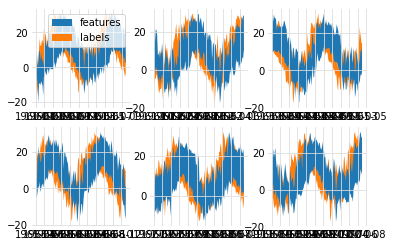

In [14]:
# Check that consecutive training sequences from the same weather station are indeed consecutive
WEATHER_STATION = 2
utils_display.picture_this_5(visu_data, WEATHER_STATION)

<a name="assignment2"></a><a name="assignment3"></a>
## The model definition

<div class="alert alert-block alert-info">
***Assignement #2*** Implement the RNN model. You can copy-paste it from the previous exercise but you will have to make one modification: we are now predicting vectors of 2 values (Tmin, Tmax) instead of single values. Train then evaluate to see if you are getting better results.
</div>

<div class="alert alert-block alert-info">
***Assignement #3*** Temperatures are noisy. If we ask the model to predict the naxt data point, noise might drown the trend and the model will not train. The trend should be clearer if we ask the moder to look further ahead. You can use the [hyperparameter](#hyperparameters) N_FORWARD to shift the target sequences by more than 1. Try values between 4 and 16 and see how [training sequences](#trainseq) look.<br/>
<br/>
If the model predicts N_FORWARD in advance, you will also need it to output N_FORWARD predicted values instead of 1. Please check that the output of your model is indeed `Yout = Yr[:,-N_FORWARD:,:]`. The inference part has already been adjusted to generate the sequence by blocks of N_FORWARD points. You can have a [look at it](#inference).<br/>
<br/>
Train and evaluate to see if you are getting better results. ***In the end, use this value: N_FORWARD=8***
</div>

<a name="assignment4"></a>
<div class="alert alert-block alert-info">
***Assignement #4*** Try adjusting the follwing parameters:<ol><ol>
    <li> Use a stacked RNN cell with 2 layers with in the model:<br/>
```
cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
```
        <br/>Do not forget to set N_LAYERS=2 in [hyperparameters](#hyperparameters)
    </li>
    <li>Increase RNN_CELLSIZE -> 128 to allow the cells to model more complex behaviors.</li>
    <li>Regularisation: add a decaying learning rate. Replace learning_rate=0.01 with:<br/>
``` 
learning_rate = 0.001 + tf.train.exponential_decay(0.01, step, 1000, 0.5) # 0.001+0.01*0.5^(step/1000)
``` </li>
    <li>Regularisation: add dropout between cell layers.<br/>
```        
cells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells]
```
<br/>
        Check that you have a good value for DROPOUT_PKEEP in [hyperparameters](#hyperparameters). 0.7 should do. Also check that dropout is deactivated i.e. dropout_pkeep=1.0 during [inference](#inference).
    </li>
</ol></ol>
Play with these options until you get a good fit for at least 1.5 years.
</div>

![deep RNN schematic](images/RNN2.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 2]<br/>
  Y shape [BATCHSIZE, SEQLEN, 2]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*NLAYERS]
</div>
When executed, this function instantiates the Tensorflow graph for our model.

In [15]:
def model_rnn_fn(features, Hin, labels, step, dropout_pkeep):
    X = features  # shape [BATCHSIZE, SEQLEN, DATA_SIZE], DATA_SIZE=2 for (Tmin, Tmax)
    batchsize = tf.shape(X)[0]  # allow for variable batch size
    seqlen = tf.shape(X)[1]  # allow for variable sequence length
    
    
    # --- dummy model that does almost nothing (one trainable variable is needed) ---
    # --- Dhe regression layer is missing too!                                   ---
    # --- When adding it, keep in mind we are prediction two values: Tmin, Tmax ---
    #Yr = X * tf.Variable(tf.transpose(tf.ones([RNN_CELLSIZE,RNN_CELLSIZE])), name = "dummy")
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE, activation=ACTIVATION) for _ in range(N_LAYERS)]
    
    # optional: dropout useful between cell layers only: no output dropout on last cell
    cells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells]
    
    cells = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
    
    Yn, H = tf.nn.dynamic_rnn(cell=cells, inputs=X, initial_state=Hin, dtype=tf.float32)
        
    # This is the regression layer. It is already implemented.
    # Yn [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, DATA_SIZE) # Yr [BATCHSIZE*SEQLEN, 1] predicting vectors of 1 element
    Yr = tf.reshape(Yr, [batchsize, seqlen, DATA_SIZE]) # Yr [BATCHSIZE, SEQLEN, DATA_SIZE]
    
    Yout = Yr[:,-N_FORWARD:,:] # Last N_FORWARD outputs. Yout [BATCHSIZE, N_FORWARD, 2]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 2]

    lr = 0.001 + tf.train.exponential_decay(0.01, step, 1000, 0.5)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op, Yr

## Instantiate the model

In [16]:
tf.reset_default_graph() # restart model graph from scratch

# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * N_LAYERS])
features = tf.placeholder(tf.float32, [None, None, 2]) # [BATCHSIZE, SEQLEN, 2]
labels = tf.placeholder(tf.float32, [None, None, 2]) # [BATCHSIZE, SEQLEN, 2]
step = tf.placeholder(tf.int32)
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op, Yr = model_rnn_fn(features, Hin, labels, step, dropout_pkeep)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [17]:
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])
saver = tf.train.Saver(max_to_keep=1)

<a name="train"></a>
## The training loop
You can re-execute this cell to continue training. <br/>
<br/>
Training data must be batched correctly, one weather station per line, continued on the same line across batches. This way, output states computed from one batch are the correct input states for the next batch. The provided utility function `rnn_multistation_sampling_temperature_sequencer` does the right thing.
![batching for RNNs](images/batching.svg)

In [18]:
losses = []
indices = []
last_epoch = 99999
last_fileid = 99999

for i, (next_features, next_labels, dates, epoch, fileid) in enumerate(
    utils_batching.rnn_multistation_sampling_temperature_sequencer(train_filenames,
                                                                   RESAMPLE_BY,
                                                                   BATCHSIZE,
                                                                   SEQLEN,
                                                                   N_FORWARD,
                                                                   NB_EPOCHS, tminmax=True)):
    
    # reinintialize state between epochs or when starting on data from a new weather station
    if epoch != last_epoch or fileid != last_fileid:
        batchsize = next_features.shape[0]
        H_ = np.zeros([batchsize, RNN_CELLSIZE * N_LAYERS])
        print("State reset")

    #train
    feed = {Hin: H_, features: next_features, labels: next_labels, step: i, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _, Yr_ = sess.run([Yout, H, loss, train_op, Yr], feed_dict=feed)
    
    # print progress
    if i%20 == 0:
        print("{}: epoch {} loss = {} ({} weather stations this epoch)".format(i, epoch, np.mean(loss_), fileid+1))
        sys.stdout.flush()
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)
     # This visualisation can be helpful to see how the model "locks" on the shape of the curve
#    if i%100 == 0:
#        plt.figure(figsize=(10,2))
#        plt.fill_between(dates, next_features[0,:,0], next_features[0,:,1]).set_alpha(0.2)
#        plt.fill_between(dates, next_labels[0,:,0], next_labels[0,:,1])
#        plt.fill_between(dates, Yr_[0,:,0], Yr_[0,:,1]).set_alpha(0.8)
#        plt.show()
        
    last_epoch = epoch
    last_fileid = fileid
    
# save the trained model
SAVEDMODEL = JOB_DIR + "/ckpt" + str(int(time.time()))
tf.saved_model.simple_save(sess, SAVEDMODEL,
                           inputs={"features":features, "Hin":Hin, "dropout_pkeep":dropout_pkeep},
                           outputs={"Yout":Yout, "H":H})

Loading 28 files............................
State reset
0: epoch 0 loss = 295.47442626953125 (28 weather stations this epoch)
20: epoch 0 loss = 34.12244415283203 (28 weather stations this epoch)
State reset
40: epoch 1 loss = 21.731082916259766 (28 weather stations this epoch)
State reset
60: epoch 2 loss = 23.287105560302734 (28 weather stations this epoch)
80: epoch 2 loss = 22.26374626159668 (28 weather stations this epoch)
State reset
100: epoch 3 loss = 22.25288200378418 (28 weather stations this epoch)
State reset
120: epoch 4 loss = 19.252344131469727 (28 weather stations this epoch)
State reset
140: epoch 5 loss = 24.03689956665039 (28 weather stations this epoch)
160: epoch 5 loss = 20.970317840576172 (28 weather stations this epoch)
State reset
180: epoch 6 loss = 18.821792602539062 (28 weather stations this epoch)
State reset
200: epoch 7 loss = 19.095701217651367 (28 weather stations this epoch)
220: epoch 7 loss = 23.615163803100586 (28 weather stations this epoch)
State

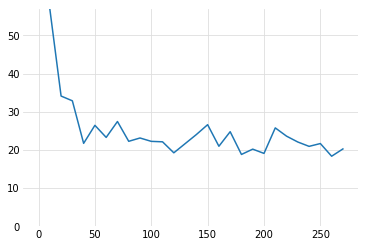

In [19]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

<a name="inference"></a>
## Inference
This is a generative model: run an trained RNN cell in a loop. This time, with N_FORWARD>1, we generate the sequence by blocks of N_FORWAD data points instead of point by point. The RNN is unrolled across N_FORWARD steps, takes in a the last N_FORWARD data points and predicts the next N_FORWARD data points and so on in a loop. State must be passed around correctly.

In [20]:
def prediction_run(predict_fn, prime_data, run_length):
    H = np.zeros([1, RNN_CELLSIZE * N_LAYERS]) # zero state initially
    Yout = np.zeros([1, N_FORWARD, 2])
    data_len = prime_data.shape[0]-N_FORWARD

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data[:-N_FORWARD])
        Yin = np.reshape(Yin, [1, data_len, 2]) # reshape as one sequence of pairs (Tmin, Tmax)
        r = predict_fn({'features': Yin, 'Hin':H, 'dropout_pkeep':1.0}) # no dropout during inference
        Yout = r["Yout"]
        H = r["H"]
        
        # initaily, put real data on the inputs, not predictions
        Yout = np.expand_dims(prime_data[-N_FORWARD:], axis=0)
        # Yout shape [1, N_FORWARD, 2]: batch of a single sequence of length N_FORWARD of (Tmin, Tmax) data pointa
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length//N_FORWARD+1):
        r = predict_fn({'features': Yout, 'Hin':H, 'dropout_pkeep':1.0}) # no dropout during inference
        Yout = r["Yout"]
        H = r["H"]
        results.append(Yout[0]) # shape [N_FORWARD, 2]
        
    return np.concatenate(results, axis=0)[:run_length]

<a name="valid"></a>
## Validation

In [21]:
QYEAR = 365//(RESAMPLE_BY*4)
YEAR = 365//(RESAMPLE_BY)

# Try starting predictions from January / March / July (resp. OFFSET = YEAR or YEAR+QYEAR or YEAR+2*QYEAR)
# Some start dates are more challenging for the model than others.
OFFSET = 4*YEAR+1*QYEAR

PRIMELEN=7*YEAR
RUNLEN=4*YEAR
RMSELEN=3*365//(RESAMPLE_BY*2) # accuracy of predictions 1.5 years in advance

In [22]:
# Restore the model from the last checkpoint saved previously.

# Alternative checkpoints:
# Once you have trained on all 1666 weather stations on Google Cloud ML Engine, you can load the checkpoint from there.
# SAVEDMODEL = "gs://{BUCKET}/sinejobs/sines_XXXXXX_XXXXXX/ckptXXXXXXXX"
# A sample checkpoint is provided with the lab. You can try loading it for comparison.
# You will have to use the following parameters and re-run the entire notebook:
# N_FORWARD = 8, RESAMPLE_BY = 5, RNN_CELLSIZE = 128, N_LAYERS = 2
# SAVEDMODEL = "temperatures_best_checkpoint"

predict_fn = tf.contrib.predictor.from_saved_model(SAVEDMODEL)

INFO:tensorflow:Restoring parameters from checkpoints/ckpt1544792653/variables/variables


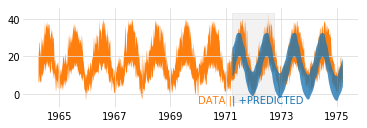

RMSE on 109 predictions (shaded area): 5.483082126450734


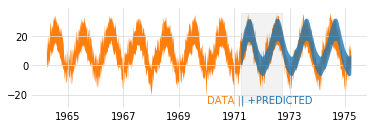

RMSE on 109 predictions (shaded area): 3.5784592484268005


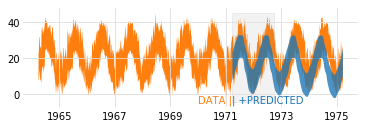

RMSE on 109 predictions (shaded area): 6.30500645258561


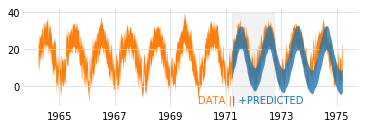

RMSE on 109 predictions (shaded area): 4.374009885719064


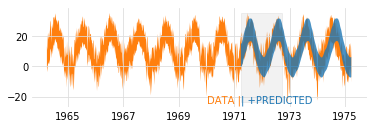

RMSE on 109 predictions (shaded area): 4.276147997769802


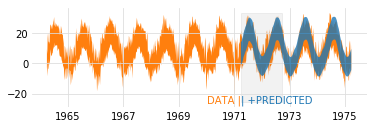

RMSE on 109 predictions (shaded area): 4.177111884993165


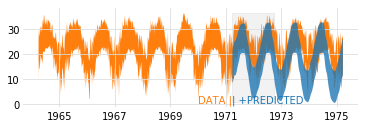

RMSE on 109 predictions (shaded area): 5.750432179756016


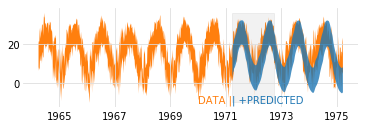

RMSE on 109 predictions (shaded area): 4.177391535056718


In [23]:
for evaldata in evaltemps:
    prime_data = evaldata[OFFSET:OFFSET+PRIMELEN]
    results = prediction_run(predict_fn, prime_data, RUNLEN)
    #print(results)
    utils_display.picture_this_6(evaldata, evaldates, prime_data, results, PRIMELEN, RUNLEN, OFFSET, RMSELEN)

In [24]:
rmses = []
bad_ones = 0
for offset in [YEAR, YEAR+QYEAR, YEAR+2*QYEAR]:
    for evaldata in evaltemps:
        prime_data = evaldata[offset:offset+PRIMELEN]
        results = prediction_run(predict_fn, prime_data, RUNLEN)
        rmse = math.sqrt(np.mean((evaldata[offset+PRIMELEN:offset+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
        rmses.append(rmse)
        if rmse>7: bad_ones += 1
        print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))
print("Average RMSE on {} weather stations: {} ({} really bad ones, i.e. >7.0)".format(len(evaltemps), np.mean(rmses), bad_ones))
sys.stdout.flush()

RMSE on 109 predictions (shaded area): 6.294100816700166
RMSE on 109 predictions (shaded area): 4.200709069626711
RMSE on 109 predictions (shaded area): 5.912807525577277
RMSE on 109 predictions (shaded area): 6.108835438898817
RMSE on 109 predictions (shaded area): 5.362141513131132
RMSE on 109 predictions (shaded area): 3.8719289329690185
RMSE on 109 predictions (shaded area): 5.853320180620697
RMSE on 109 predictions (shaded area): 5.736347231508611
RMSE on 109 predictions (shaded area): 4.56250695442258
RMSE on 109 predictions (shaded area): 4.147645623583034
RMSE on 109 predictions (shaded area): 6.984720528319022
RMSE on 109 predictions (shaded area): 4.053717223368174
RMSE on 109 predictions (shaded area): 3.9364871874040555
RMSE on 109 predictions (shaded area): 4.599421335798776
RMSE on 109 predictions (shaded area): 4.994868469839226
RMSE on 109 predictions (shaded area): 3.9160628593955824
RMSE on 109 predictions (shaded area): 4.000659396838313
RMSE on 109 predictions (shad

Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.